In [ ]:
import pandas as pd
import seaborn as sns
import pymc3 as pm
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

# Online Dating Data 

According to The Pew Research Center, 15% of US adults have used online dating to meet a potential mate. However, no one is discussing the probability of meeting a mate. The dating site OkCupid has released metrics for reply rates based on race. I've recorded my personal response rates and categorized them into five groups: White, Latina, Asian, Black, Unknown. This notebook analyzes my response rates through the lens of Bayesian Statistics through A/B testing for each demographic. The notebook is segmented into six sections followed by a conclusion:  
1. Gathering Data 
2. Preparing Data 
3. Choosing a Model
4. Evaluating 
5. Hyperparameter Tuning 
6. Predictions

The testing revealed that for my average reply rate of 23.1% with a 95 % CI (17.6%, 28.2%) overlapped with OkCupid's own data for my for demographic—23.1% for Latino male. The data reveals that response rates for males, in general, is low. For a male of color, online dating may not be the best use of time.    

Ref: https://www.pewresearch.org/fact-tank/2016/02/29/5-facts-about-online-dating/

# 1. Gathering Data: 
The code below loads the Excel file and selects the data within the first sheet. The data was collected by browsing the messages in my inbox and registering replies into an Excel file

In [47]:
x1 = pd.ExcelFile('../data/response_data.xlsx')  
x1.sheet_names
df = x1.parse("Sheet1", header = 17, usecols = [0,1,2,3,4,5,6,7,8])
df.tail()

,Date,Contact,Length,Ethnicity,Response,Age,Meeting,Single,Match
249,2017-08-04,NaN,5.0,W,NaN,30.0,NaN,NaN,93.0
250,2017-08-05,NaN,20.0,W,1.0,33.0,NaN,NaN,90.0
251,2017-08-11,NaN,5.0,B,NaN,30.0,NaN,NaN,78.0
252,2017-08-16,NaN,17.0,A,NaN,29.0,NaN,NaN,59.0
253,2017-08-19,NaN,32.0,W,1.0,32.0,NaN,NaN,86.0


# 2. Preparing that data

In [48]:
#Change W to White, U to Unknown, NaN to Unknown, L to Latina, A to Asian, B to Black
df.Ethnicity.replace( 'U', 'Unknown', inplace = True)
df.Ethnicity.fillna( 'Unknown' , inplace = True)
df.Response.fillna( 0 , inplace = True)
df.Meeting.fillna( 0 , inplace = True)
df.Ethnicity.replace( 'W', 'White', inplace = True)
df.Ethnicity.replace( 'L', 'Latina', inplace = True)
df.Ethnicity.replace( 'A', 'Asian', inplace = True)
df.Ethnicity.replace( 'B', 'Black', inplace = True)

## Visualize messages to Groups 
The scatter plot below doesn't appear to demonstrate any correlation between message length ("Length"), match percentage ("Match"), age ('Age'), or replies ('Response'). The closest to a trend is perhaps Match versus Age. It makes sense that I would have a higher match percentage with people closer to my age.

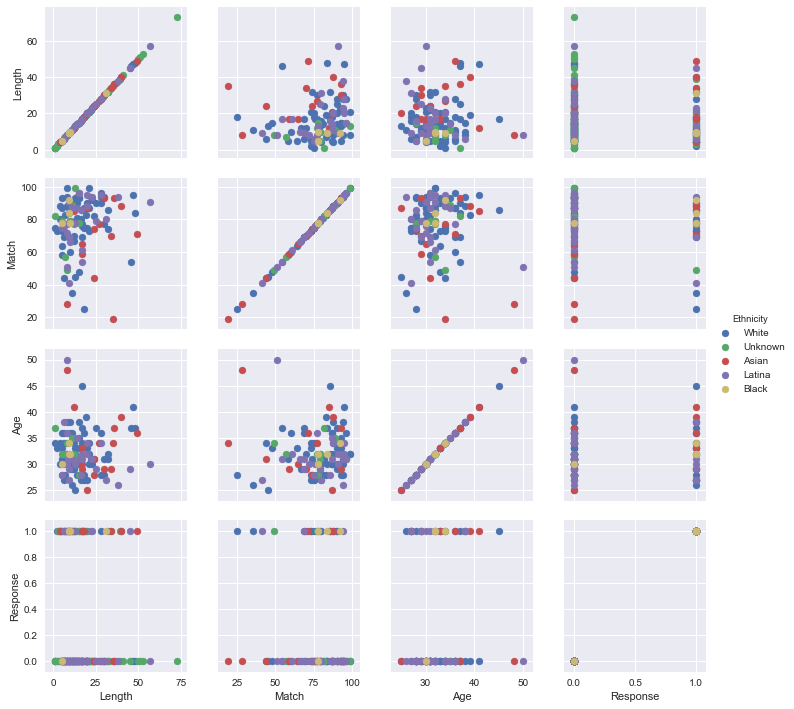

In [49]:
g = sns.PairGrid(df, vars=["Length", "Match", 'Age', 'Response'], hue="Ethnicity")
g.map(plt.scatter)
g.add_legend();

## Messages to all groups

The plot below demonstrates the total number of messages sent, and the total number of replies. 

In [50]:
sent =  df.loc[  (df.Contact != 1 ) , 'Response' ]   #messages sent by me 

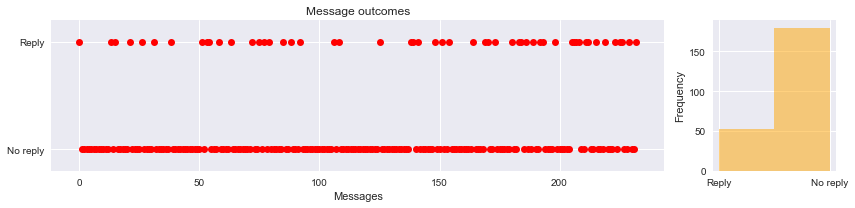

In [51]:
# Plot the data
fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(len(sent)), sent, 'ro')
ax2.hist(-sent, bins=2, alpha = .5, color = 'orange')

ax1.yaxis.set(ticks=(0,1), ticklabels=('No reply', 'Reply'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Reply', 'No reply'));

ax1.set(title='Message outcomes', xlabel='Messages', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()


#### Now let's make function to plot outcomes for individual goups

In [52]:
def plot_outcomes(str):
    group = df.loc[  (df.Contact != 1 ) & (df.Ethnicity == str ), 'Response' ]   #messages sent by me to group 
    
    fig = plt.figure(figsize=(12,2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    ax1.plot(range(len(group)), group, 'ro')
    ax2.hist(-group, bins=2, alpha = .5, color = 'orange')

    ax1.yaxis.set(ticks=(0,1), ticklabels=('No reply', 'Reply'))
    ax2.xaxis.set(ticks=(-1,0), ticklabels=('Reply', 'No reply'));

    ax1.set(title='Message outcomes to {} group'.format(str), xlabel='Messages', ylim=(-0.2, 1.2))
    ax2.set(ylabel='Frequency')

    
    return fig.tight_layout()

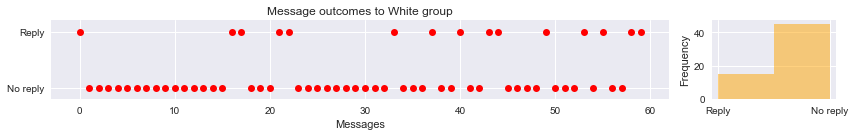

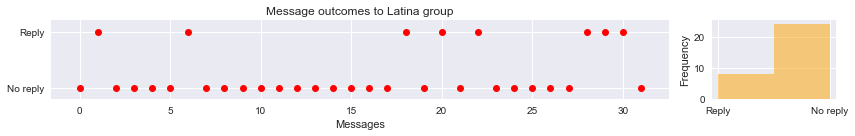

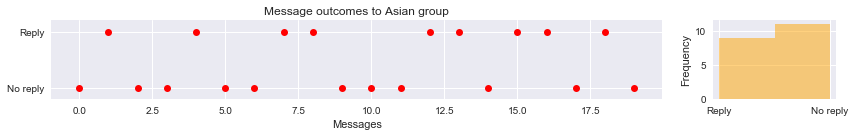

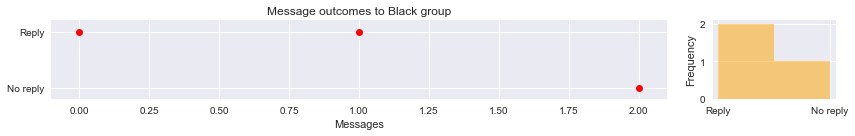

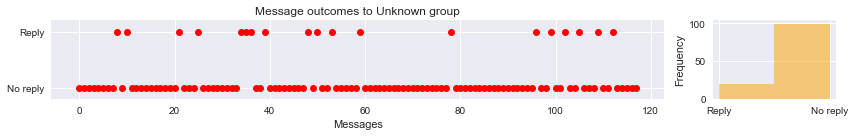

In [53]:
plot_outcomes("White"), plot_outcomes("Latina"), plot_outcomes("Asian"), plot_outcomes("Black"), plot_outcomes("Unknown");

### Histogram of Match % and messaged 

According to OkCupid, the Match % demonstrates how well one matches up against a potential partner. From the histogram above we can see the median for matches contacted was 80%. 

'Match % average of 78 with a median of 80'

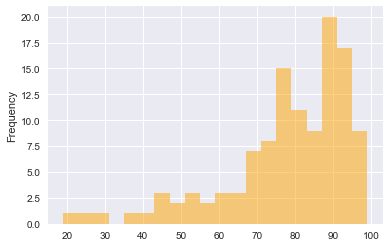

In [54]:
df.Match.plot.hist(alpha = .5, color = 'orange', bins=20);
match_mean = "%.0f" % df.Match.mean()
match_median = "%.0f" % df.Match.median()
'Match % average of {} with a median of {}'.format(match_mean, match_median)

# 3. Choosing a Model

### Response rate for all contacted with Bayesian Statistics 
The reply data is modeled with a Bernoulli distribution. The distribution is a function of the parameter theta—the reply rate. Since we don't know much about my previous reply rates, we'll model theta prior as a Uniform distribution. 

In [55]:
with pm.Model():
    # prior 
    theta = pm.Uniform('theta', 0, 1) 
    
    # likelihood 
    Y = pm.Bernoulli('Y', p = theta, observed = sent )

    # Inference
    trace = pm.sample(4000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 128.52:   3%|▎         | 6776/200000 [00:01<00:27, 6911.39it/s]
Convergence archived at 7400
Interrupted at 7,400 [3%]: Average Loss = 139.33
100%|██████████| 4500/4500 [00:03<00:00, 1441.40it/s]


# 4. Evaluating

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1183bb5c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121dcd518>]], dtype=object)

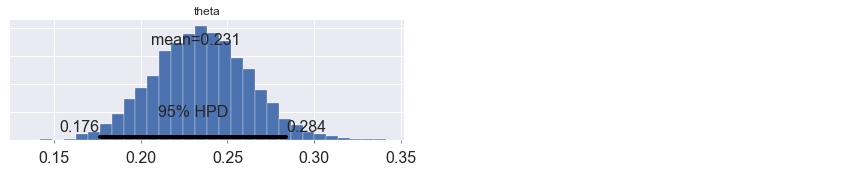

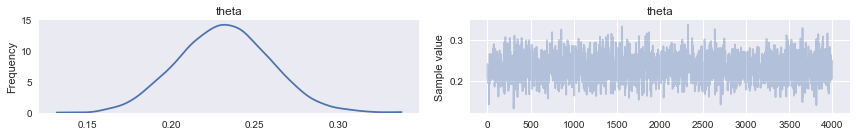

In [56]:
pm.plots.plot_posterior(trace)
pm.traceplot(trace)

In [57]:
pm.summary(trace)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.231            0.028            0.001            [0.176, 0.284]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.178          0.212          0.231          0.250          0.287



I have an average reply rate of 23.1% with a 95 % CI (17.6%, 28.4%). From the plot below we see this is in agreement with OKC data for a Latino male. The next step is to look at response rate per individual groups.

<img src="../figures/Reply_rate_by_sender.png">
Source: [OkCupid Blog](https://theblog.okcupid.com/how-your-race-affects-the-messages-you-get-39c68771b99e)

# 5. Hyperparameter tuning

### Hierarchical Model:  A/B Test  

In the Classical Bernoulli distribution, I assumed a uniform prior. However, we can use a Beta distribution, with hyper parameters a and b. This custom Beta distribution returns the logit, which incorporates the mean log(a/b) and the log of the "sample size", log(a+b). This analysis incorporates ideas about the logit to get desired mathematical properties when sampling for a and b.

Below I build a dataframe with trials and success for each group

In [58]:
Groups = ['White', 'Latina', 'Asian', 'Black', 'Unknown']

#function to build array for dataframe 
def n_trials(group_list):
    new_array = []
    for item in group_list:
        a =  df.loc[  (df.Contact != 1 ) & (df.Ethnicity == item ), 'Response' ].sum() #replies 
        b = len( df.loc[  (df.Contact != 1 ) & (df.Ethnicity == item ), 'Response' ] ) #messages sent to specific group
        new_array.append([a,b])
    return pd.DataFrame( np.array(new_array).reshape(5,2), columns = ['Replies', 'Sent'] ).set_index([group_list])

df1 = (n_trials(Groups))
df1

,Replies,Sent
White,15.0,60.0
Latina,8.0,32.0
Asian,9.0,20.0
Black,2.0,3.0
Unknown,19.0,118.0


In [59]:
import pymc

@pymc.stochastic(dtype=np.float64)
def hyperpriors(value=[1.0, 1.0]):
    a, b = value[0], value[1]
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = hyperpriors[0]
b = hyperpriors[1]

In [60]:
# The hidden, true rate for each group.
true_rates = pymc.Beta('true_rates', a, b, size=5)

# The observed values
trials = df1.Sent.as_matrix() #Passes array of values 
successes = df1.Replies.as_matrix() #Passes array 
observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)

model = pymc.Model([a, b, true_rates, observed_values])
mcmc = pymc.MCMC(model)

# Generate 1M samples, and throw out the first 500k
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 230.2 sec

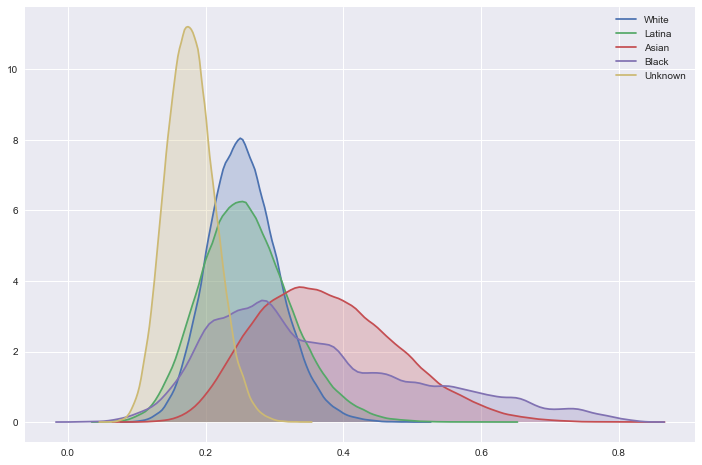

In [61]:
plt.figure(figsize=(12,8))
for i in range(5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = Groups[i])

In [62]:
# save means to list 
true_rate = []
for i in range(5):
    true_rate.append( mcmc.trace('true_rates')[:][:,i].mean() ) 

# save means to df
df1['True rate %']  = pd.DataFrame({'True rate %': true_rate}, index=df1.index)
df1['True rate %'] = (df1['True rate %']*100).round(2)

In [63]:
df1

,Replies,Sent,True rate %
White,15.0,60.0,25.59
Latina,8.0,32.0,25.93
Asian,9.0,20.0,37.76
Black,2.0,3.0,35.93
Unknown,19.0,118.0,17.81


In [64]:
mcmc.summary()


true_rates:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.256            0.051            0.001            [ 0.159  0.359]
	0.259            0.065            0.001            [ 0.134  0.389]
	0.378            0.101            0.004            [ 0.197  0.578]
	0.359            0.152            0.014            [ 0.121  0.679]
	0.178            0.035            0.001            [ 0.11   0.247]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.163            0.22            0.253          0.288         0.363
	0.143            0.214           0.255          0.3           0.4
	0.208            0.302           0.369          0.445         0.594
	0.144            0.245           0.322          0.453         0.716
	0.114            0.153           0.177          0.201         0.251
	

In [65]:
HPD = [ '15.9, 35.9', '13.4, 38.9', '19.7, 57.8', '12.1, 67.9',  '11, 24.7' ] 
df1['95% Credible Interval']  = pd.DataFrame({'95% Credible interval': HPD}, index=df1.index)
df1

,Replies,Sent,True rate %,95% Credible Interval
White,15.0,60.0,25.59,"15.9, 35.9"
Latina,8.0,32.0,25.93,"13.4, 38.9"
Asian,9.0,20.0,37.76,"19.7, 57.8"
Black,2.0,3.0,35.93,"12.1, 67.9"
Unknown,19.0,118.0,17.81,"11, 24.7"


# 6. Predictions 

Now, let's examine the posterior of the delta distribution below for the demographics 'White' and 'Latina'. The orange line at x = 0, represents where the difference between the two distributions is 0. We can see the distribution is evenly distributed about x = 0. This means most of the points sampled from White's distribution are roughly equal to those sampled from the Latina's distribution, implying White is likely to equal to Latina rates.

To get more quantitative results, we can compute the probability that 'White' replies more than 'Latina'. This can be done with any demographic permutation.

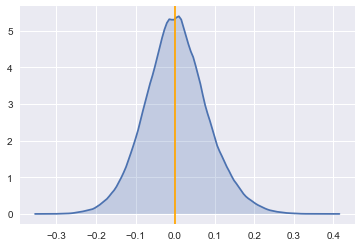

In [66]:
delta_distribution = mcmc.trace('true_rates')[:][:,1] - mcmc.trace('true_rates')[:][:,0]  #subtracts 'Latina' from 'White'

sns.kdeplot(delta_distribution, shade = True)
plt.axvline(0.00, color = 'orange');

In [67]:
print ( "Probability that 'Latina' replies MORE than 'White': %0.3f" % (delta_distribution > 0).mean() )
print ( "Probability that 'Latina' replies LESS than 'White': %0.3f" % (delta_distribution < 0).mean() )

Probability that 'Latina' replies MORE than 'White': 0.510
Probability that 'Latina' replies LESS than 'White': 0.490


# Conclusion 
The posterior of the delta distribution yields a reliable way to compare one demographics reply rate versus another. Although the reply rates for the Asian and Black demographics were high, I suspect we would see a regression to the mean with more data. 

Reply rates are informative, however, actual in-person meetings should be the key metric evaluated. The analysis below demonstrates that for approximately every 100 messages sent two dates are probable,  1.9% with a 95% CI (0.5%, 3.5%). Is that a good rate? I don't know if it's a good rate, but it does agree with the metrics of other males who have shared their online dating experience with me. Is online-dating time-effective for meeting a mate? At this point, I would have to answer in the negative. It seems like the time invested in searching, reading, and contacting profiles would be better spent on hobbies or activities where one would interact with potential mates, i.e. old school networking.

### In person Meeting percentage 
For this model, the prior is modeled as a uniform distribution. The likelihood models the in-person 'Meeting' data as a Bernoulli distribution. 

In [68]:
with pm.Model():
    # prior 
    theta = pm.Uniform('theta', 0, 1) 
    
    # likelihood 
    Y = pm.Bernoulli('Y', p = theta, observed = df.Meeting )

    # Inference
    trace = pm.sample(5000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 31.104:   5%|▍         | 9681/200000 [00:01<00:29, 6552.21it/s]
Convergence archived at 9700
Interrupted at 9,700 [4%]: Average Loss = 80.888
100%|██████████| 5500/5500 [00:03<00:00, 1500.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117e51a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1151ed5f8>]], dtype=object)

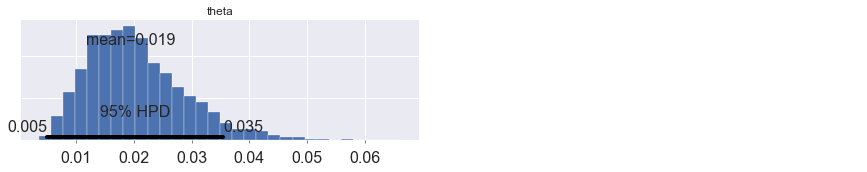

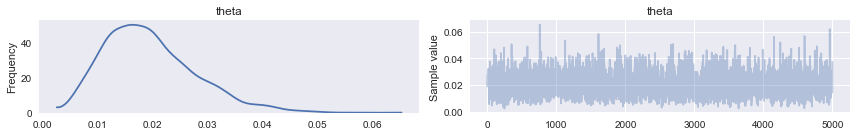

In [69]:
pm.plots.plot_posterior(trace)
pm.traceplot(trace)

In [70]:
pm.summary(trace)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.019            0.008            0.000            [0.005, 0.035]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.007          0.013          0.018          0.024          0.039



1. Gathering Data
2. Preparing that data
3. Choosing a Model
4. Training
5. Evaluating
6. Hyperparameter tuning
7. Prediction 